In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
df = pd.read_fwf('./wili dataset/x_train.txt', header=None)
X_train = df[[0]]
df = pd.read_fwf('./wili dataset/x_test.txt', header=None)
X_test = df[[0]]

In [3]:
target = pd.read_fwf('./wili dataset/y_train.txt',header = None)
y_train = target[[0]]
target = pd.read_fwf('./wili dataset/y_test.txt',header = None)
y_test = target[[0]]

In [4]:
y_train[y_train == 'be-tara'] = 'be-tarask'
y_train[y_train == 'roa-tar'] = 'roa-tara'

In [5]:
languages = ['eng', 'hin', 'mar', 'guj', 'tam', 'tcy', 'tel', 'pan', 'ben', 'mai']

In [6]:
train_index = y_train.index[y_train[0].isin(languages)].tolist()

In [7]:
test_index = y_test.index[y_test[0].isin(languages)].tolist()

In [8]:
X_train_p = X_train.iloc[train_index,:]
X_test_p = X_test.iloc[test_index,:]

In [9]:
y_train_p = y_train.iloc[train_index, :]
y_test_p = y_test.iloc[test_index, :]

### Tokenize Labels

In [10]:
label2int = {}
int2label = {}
counter = 0
for label in languages:
    if label not in label2int:
        label2int[label] = counter
        int2label[counter] = label
    counter += 1

In [11]:
pickle.dump(label2int, open('label2int.pkl', 'wb'))
pickle.dump(int2label, open('int2label.pkl', 'wb'))

### Tokenize target Variables

In [12]:
y_train_int = []
for label in y_train_p[0]:
    y_train_int.append(label2int[label])

In [13]:
y_test_int = []
for label in y_test_p[0]:
    y_test_int.append(label2int[label])

### Data Preprocessing

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
vectorizer = TfidfVectorizer(analyzer='char',min_df=25,lowercase=True, norm='l2')

In [16]:
vectorizer.fit(X_train_p[0])

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=25,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
X_train2int = vectorizer.transform(X_train_p[0]).toarray()

In [18]:
X_test2int = vectorizer.transform(X_test_p[0]).toarray()

In [19]:
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))

### Scaler

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
sc = StandardScaler()

In [22]:
sc.fit(X_train2int)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
X_train2int_sc = sc.transform(X_train2int)
X_test2int_sc = sc.transform(X_test2int)

In [24]:
pickle.dump(sc, open('scaler.pkl', 'wb'))

### PCA

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=80)

In [27]:
pca.fit(X_train2int_sc)

PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
X_train_pca = pca.transform(X_train2int_sc)

In [29]:
X_test_pca = pca.transform(X_test2int_sc)

In [30]:
import matplotlib.pyplot as plt

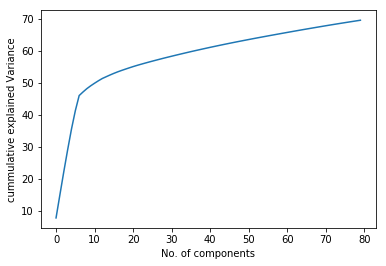

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("No. of components")
plt.ylabel("cummulative explained Variance");

In [32]:
pickle.dump(pca, open('pca.pkl', 'wb'))

### One Hot Encoding

In [33]:
from sklearn.preprocessing import OneHotEncoder

In [34]:
y_train_int = np.array(y_train_int).reshape(-1, 1)
y_test_int = np.array(y_test_int).reshape(-1, 1)

In [35]:
enc = OneHotEncoder()

In [36]:
enc.fit(y_train_int)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [37]:
y_train_enc = enc.transform(y_train_int)
y_test_enc = enc.transform(y_test_int)

## Design ANN

In [38]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import model_from_json

/home/jatin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [39]:
clf = Sequential()
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu', input_dim = 80))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu'))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu'))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim =10  , kernel_initializer = 'uniform', activation='softmax'))

/home/jatin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", input_dim=80, units=60)`
  
/home/jatin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", units=60)`
  after removing the cwd from sys.path.
/home/jatin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", units=60)`
  
/home/jatin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="softmax", units=10)`
  


In [40]:
clf.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [41]:
with tf.device('/gpu:0'):
    history = clf.fit(X_train_pca, y_train_enc, batch_size=32, epochs=50, validation_data=(X_test_pca,y_test_enc))

Train on 5000 samples, validate on 5000 samples
Epoch 1/50
5000/5000 [==============================] - 1s 287us/step - loss: 1.0780 - acc: 0.6808 - val_loss: 0.2083 - val_acc: 0.9642
Epoch 2/50
5000/5000 [==============================] - 1s 148us/step - loss: 0.1809 - acc: 0.9586 - val_loss: 0.1439 - val_acc: 0.9652
Epoch 3/50
5000/5000 [==============================] - 1s 152us/step - loss: 0.1555 - acc: 0.9636 - val_loss: 0.1402 - val_acc: 0.9668
Epoch 4/50
5000/5000 [==============================] - 1s 144us/step - loss: 0.1392 - acc: 0.9674 - val_loss: 0.1374 - val_acc: 0.9660
Epoch 5/50
5000/5000 [==============================] - 1s 150us/step - loss: 0.1335 - acc: 0.9674 - val_loss: 0.1344 - val_acc: 0.9664
Epoch 6/50
5000/5000 [==============================] - 1s 202us/step - loss: 0.1277 - acc: 0.9678 - val_loss: 0.1395 - val_acc: 0.9656
Epoch 7/50
5000/5000 [==============================] - 1s 151us/step - loss: 0.1213 - acc: 0.9694 - val_loss: 0.1374 - val_acc: 0.9648


In [42]:
model_json = clf.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
clf.save_weights("model.h5")

## Evaluation

In [43]:
y_pred_test_label = clf.predict(X_test_pca)
y_pred_train_label = clf.predict(X_train_pca)

In [44]:
y_pred_test = np.argmax(y_pred_test_label, axis=1)
y_pred_train = np.argmax(y_pred_train_label, axis=1)

In [45]:
y_train_true = y_train_int.astype(np.int)
y_test_true = y_test_int.astype(np.int)

## Graph Plot

### Model Accuracy Graph

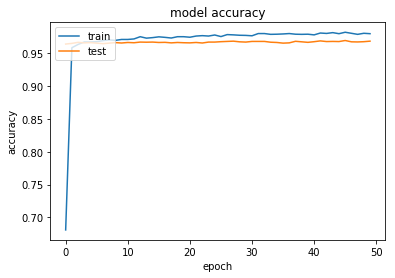

In [46]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Loss Graph

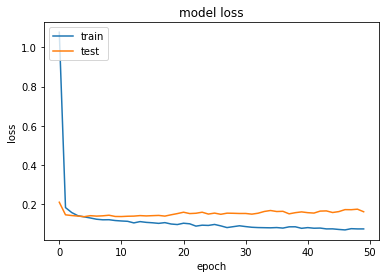

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Classification Report

In [48]:
from sklearn.metrics import classification_report

#### Train Data report

In [49]:
print(classification_report(y_train_true, y_pred_train))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95       500
          1       0.97      0.99      0.98       500
          2       1.00      0.99      0.99       500
          3       1.00      0.97      0.98       500
          4       1.00      1.00      1.00       500
          5       1.00      1.00      1.00       500
          6       1.00      0.96      0.98       500
          7       1.00      1.00      1.00       500
          8       1.00      0.99      0.99       500
          9       1.00      0.97      0.98       500

avg / total       0.99      0.99      0.99      5000



#### Test Data Report

In [50]:
print(classification_report(y_test_true, y_pred_test))

             precision    recall  f1-score   support

          0       0.84      0.97      0.90       500
          1       0.96      0.96      0.96       500
          2       0.98      0.96      0.97       500
          3       0.99      0.97      0.98       500
          4       0.99      0.99      0.99       500
          5       1.00      1.00      1.00       500
          6       1.00      0.94      0.97       500
          7       1.00      0.98      0.99       500
          8       0.99      0.96      0.98       500
          9       0.97      0.94      0.96       500

avg / total       0.97      0.97      0.97      5000



## Confusion Matrix

In [51]:
from sklearn.metrics import confusion_matrix

### Train data

In [52]:
print(confusion_matrix(y_pred_train, y_train_true))

[[499   4   5  15   2   0  18   1   2   3]
 [  1 496   0   0   0   0   1   0   1  12]
 [  0   0 495   0   0   0   0   0   0   0]
 [  0   0   0 485   0   0   0   0   0   0]
 [  0   0   0   0 498   0   0   0   0   0]
 [  0   0   0   0   0 500   0   0   1   0]
 [  0   0   0   0   0   0 481   0   0   0]
 [  0   0   0   0   0   0   0 498   0   0]
 [  0   0   0   0   0   0   0   1 496   0]
 [  0   0   0   0   0   0   0   0   0 485]]


### Test data

In [53]:
print(confusion_matrix(y_pred_test, y_test_true))

[[487   6  13  13   4   0  26   8  14  11]
 [  2 478   2   0   0   0   0   0   3  14]
 [  3   2 482   0   0   0   0   0   0   3]
 [  4   0   0 485   1   0   0   0   2   0]
 [  0   1   0   0 494   0   2   0   0   0]
 [  2   0   0   0   0 500   0   0   0   0]
 [  0   0   0   1   0   0 472   0   0   0]
 [  0   0   0   0   0   0   0 492   0   0]
 [  2   1   0   1   1   0   0   0 481   0]
 [  0  12   3   0   0   0   0   0   0 472]]


### Making Single Prediction

In [54]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [55]:
vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))
pca = pickle.load(open('pca.pkl', 'rb'))
label2int = pickle.load(open('label2int.pkl', 'rb'))
int2label = pickle.load(open('int2label.pkl', 'rb'))

In [56]:
input_single = "मेरा नाम जतिन है"
X_single = pd.DataFrame(data=[input_single], index=None)
X_single.to_csv('input.csv', encoding='utf-8', sep='\n', index=False,header=None)
X_single = pd.read_fwf('input.csv', delimiter = '\n', header = None, squeeze = True)
X_single

0    मेरा नाम जतिन है
Name: 0, dtype: object

In [57]:
X_single = vectorizer.transform(X_single).toarray()
X_single = pca.transform(X_single)
y_pred_single = model.predict(X_single)

In [58]:
y_pred_single

array([[0.05528809, 0.49289688, 0.06614693, 0.02590204, 0.00716054,
        0.00172684, 0.05814506, 0.00587617, 0.03158203, 0.2552755 ]],
      dtype=float32)

In [59]:
y_pred_single_val = np.argmax(y_pred_single, axis=1)

In [60]:
int2label[y_pred_single_val[0]]

'hin'